In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

In [3]:
train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

In [4]:
print(f'Data Shape : {train.shape}')

Data Shape : (3960, 82)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

Missing Target Value:
1224

After filt out:
2736


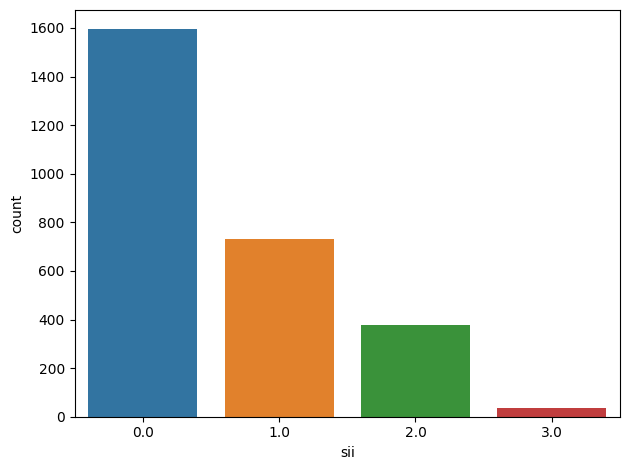

In [6]:
import seaborn as sns
# Check target column

print('Missing Target Value:')
print(train['sii'].isna().sum())

# filter out missing target
filt_train = train[train['sii'].notna()]
print('\nAfter filt out:')
print(filt_train.shape[0])

sns.countplot(x = 'sii', data = filt_train)
plt.tight_layout()
plt.show()

In [7]:
# Data Imputation
mis_cols = [col for col in train.columns if col not in test.columns]
mis_cols

['PCIAT-Season',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'sii']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Columns to drop: 13


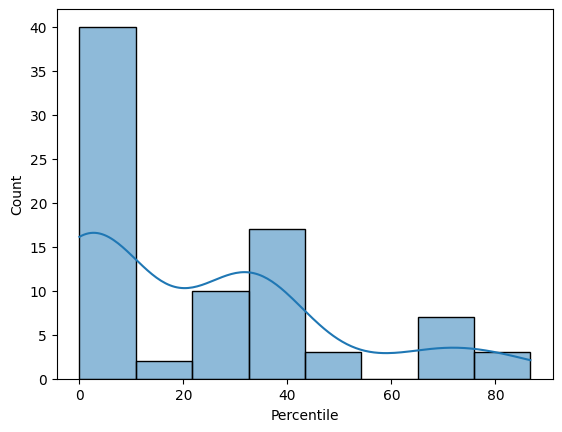

In [8]:
# Make standard for cutoff
missing_values = filt_train.isnull().sum()
missing_percentile = (missing_values / len(filt_train)) * 100


missing_dat = pd.DataFrame({
    'Missing Value': missing_values,
    'Percentile': missing_percentile
})

missing_dat = missing_dat.sort_values(by='Percentile', ascending=False)


sns.histplot(data=missing_dat, x='Percentile', kde=True)


columns_to_drop = missing_dat[missing_dat['Percentile'] >= 40].index #40
print(f'Columns to drop: {len(columns_to_drop)}')

In [9]:
clean_train = filt_train.drop(columns=columns_to_drop)

print(f'After Clean out: {clean_train.shape[1]}')

After Clean out: 69


In [10]:
from sklearn.impute import KNNImputer, SimpleImputer
num_imputer = KNNImputer(n_neighbors=5)

numerical_cols = clean_train.select_dtypes(include=['float64', 'int64']).columns

clean_train[numerical_cols] = num_imputer.fit_transform(clean_train[numerical_cols])

In [11]:
obj_imputer = SimpleImputer(strategy='most_frequent')

categorical_cols = clean_train.select_dtypes(include=['object', 'category']).columns

clean_train[categorical_cols] = obj_imputer.fit_transform(clean_train[categorical_cols])

In [12]:
clean_train_noid = clean_train.drop(columns='id')

In [13]:
season_map = {'Spring' : 1, 'Summer' : 2, 'Fall' : 3, 'Winter' : 4}
season_cols = [col for col in clean_train_noid.columns if 'Season' in col]

for col in season_cols:
    clean_train_noid[col] = clean_train_noid[col].map(season_map)

In [14]:
# Remove pciat columns
pciat_columns = [col for col in clean_train_noid.columns if 'PCIAT-PCIAT' in col and col != 'PCIAT-PCIAT_Total']
print(clean_train_noid[pciat_columns].corrwith(clean_train_noid['PCIAT-PCIAT_Total']))

clean_train_noid = clean_train_noid.drop(columns=pciat_columns)

PCIAT-PCIAT_01    0.728246
PCIAT-PCIAT_02    0.789033
PCIAT-PCIAT_03    0.823509
PCIAT-PCIAT_04    0.625314
PCIAT-PCIAT_05    0.831484
PCIAT-PCIAT_06    0.703399
PCIAT-PCIAT_07    0.492813
PCIAT-PCIAT_08    0.770630
PCIAT-PCIAT_09    0.721021
PCIAT-PCIAT_10    0.761529
PCIAT-PCIAT_11    0.684858
PCIAT-PCIAT_12    0.411792
PCIAT-PCIAT_13    0.772177
PCIAT-PCIAT_14    0.722164
PCIAT-PCIAT_15    0.824317
PCIAT-PCIAT_16    0.769773
PCIAT-PCIAT_17    0.824338
PCIAT-PCIAT_18    0.801978
PCIAT-PCIAT_19    0.737316
PCIAT-PCIAT_20    0.754248
dtype: float64


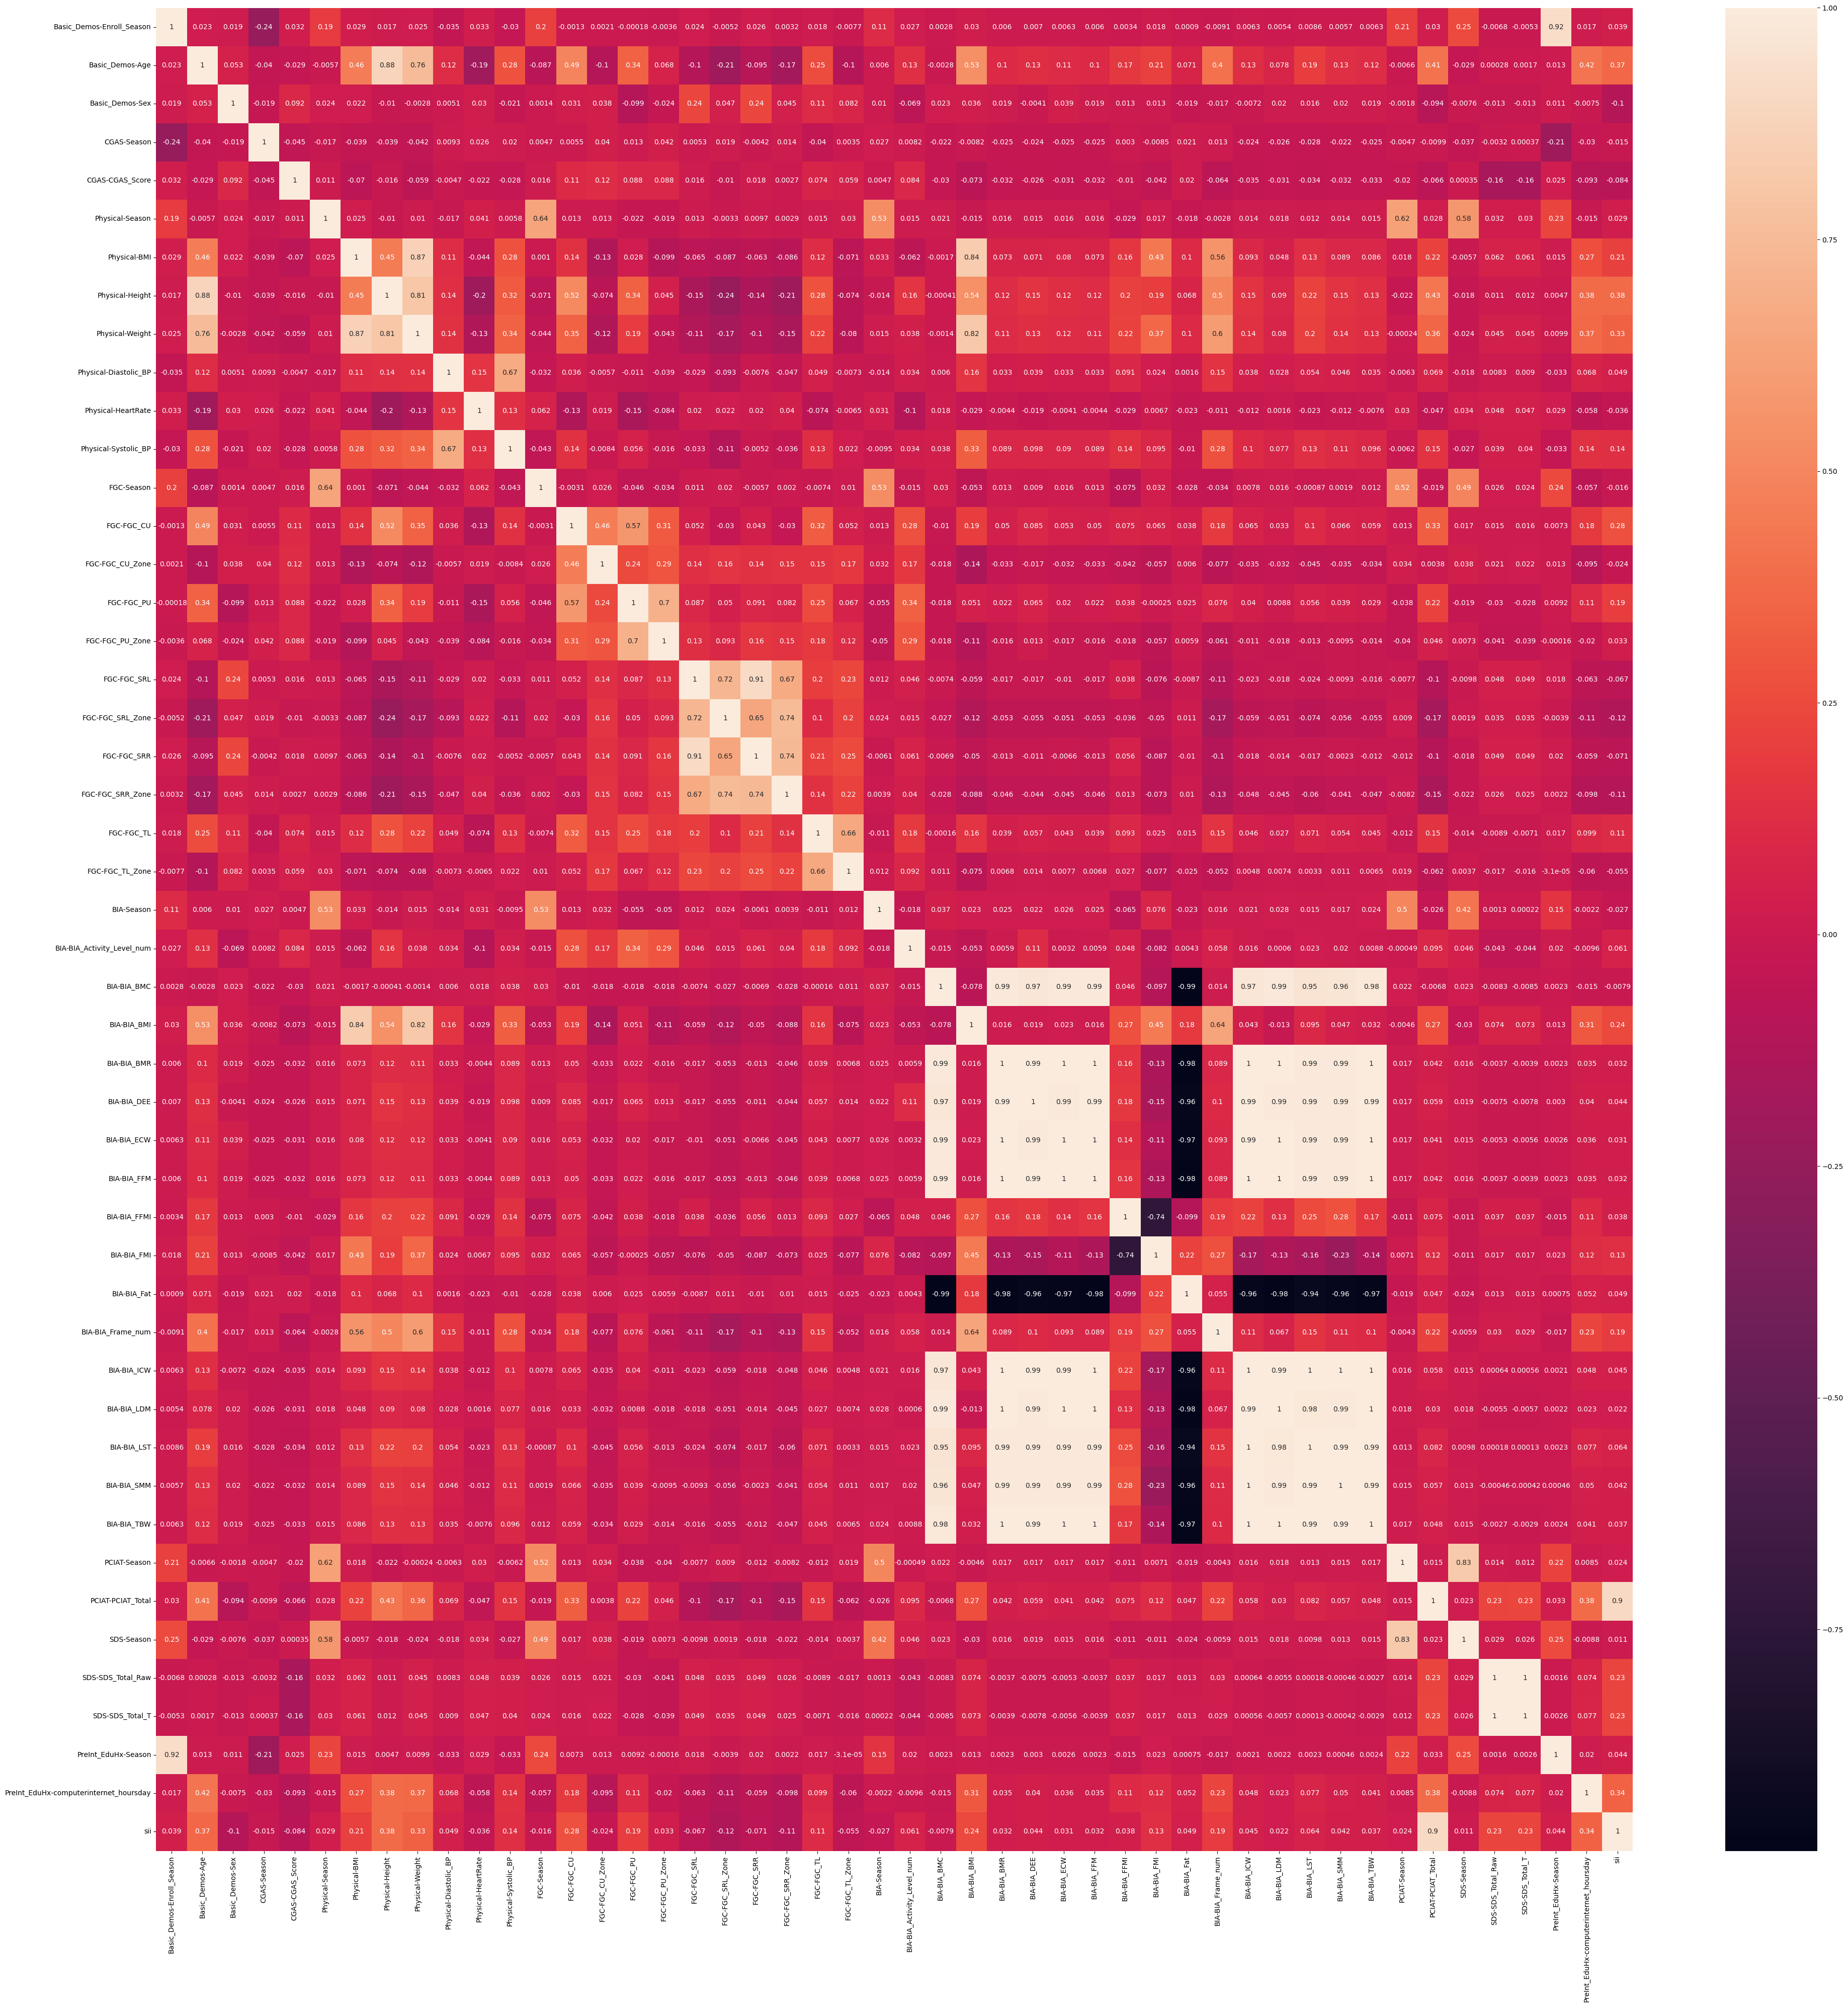

In [15]:
corr_matrix = clean_train_noid.corr()

plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True)
plt.tight_layout()
plt.show()

In [16]:
threshold = 0.8

drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j] > threshold):
            colname = corr_matrix.columns[i]
            drop.add(colname)

drop

{'BIA-BIA_BMI',
 'BIA-BIA_BMR',
 'BIA-BIA_DEE',
 'BIA-BIA_ECW',
 'BIA-BIA_FFM',
 'BIA-BIA_ICW',
 'BIA-BIA_LDM',
 'BIA-BIA_LST',
 'BIA-BIA_SMM',
 'BIA-BIA_TBW',
 'FGC-FGC_SRR',
 'Physical-Height',
 'Physical-Weight',
 'PreInt_EduHx-Season',
 'SDS-SDS_Total_T',
 'SDS-Season',
 'sii'}

In [17]:
drop.discard('sii')

In [18]:
clean_train_noid.drop(columns=drop, inplace=True)

In [19]:
clean_train_noid.drop(columns=['PCIAT-Season', 'PCIAT-PCIAT_Total'], inplace=True)

In [20]:
x_df = clean_train_noid.drop(columns='sii')
y_df = clean_train_noid['sii']

In [21]:
filt_test = test[x_df.columns]
test_id = test['id']

In [22]:
numerical_cols = filt_test.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = filt_test.select_dtypes(include=['object', 'category']).columns

filt_test[numerical_cols] = num_imputer.fit_transform(filt_test[numerical_cols])
filt_test[categorical_cols] = obj_imputer.fit_transform(filt_test[categorical_cols])

/tmp/ipykernel_17/3002993948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_test[numerical_cols] = num_imputer.fit_transform(filt_test[numerical_cols])
/tmp/ipykernel_17/3002993948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_test[categorical_cols] = obj_imputer.fit_transform(filt_test[categorical_cols])


In [23]:
season_map = {'Spring' : 1, 'Summer' : 2, 'Fall' : 3, 'Winter' : 4}
season_cols = [col for col in filt_test.columns if 'Season' in col]

for col in season_cols:
    filt_test[col] = filt_test[col].map(season_map)

/tmp/ipykernel_17/2046553841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_test[col] = filt_test[col].map(season_map)
/tmp/ipykernel_17/2046553841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_test[col] = filt_test[col].map(season_map)
/tmp/ipykernel_17/2046553841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [24]:
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from scipy.optimize import minimize
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import numpy as np

def quadratic_weighted_kappa(y_true, y_pred):
    rounded_y_true = threshold_Rounder(y_true, [0.5, 1.5, 2.5])
    rounded_y_pred = threshold_Rounder(y_pred, [0.5, 1.5, 2.5])

    return cohen_kappa_score(rounded_y_true, rounded_y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_y_true = threshold_Rounder(y_true, thresholds)
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    
    return -quadratic_weighted_kappa(rounded_y_true, rounded_p)

def TrainML(X, y, test_data, target_column, n_splits=5, seed=42):

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    oof_non_rounded = np.zeros(len(y), dtype=float)
    test_preds = np.zeros((len(test_data), n_splits))

    models = {
        'xgboost': XGBRegressor(
            learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8,
            colsample_bytree=0.8, reg_alpha=1, reg_lambda=5, random_state=seed
        ),
        'gradient_boost': GradientBoostingRegressor(
            learning_rate=0.05, max_depth=6, n_estimators=200, random_state=seed
        ),
        'catboost': CatBoostRegressor(
            learning_rate=0.05, depth=6, iterations=200, random_state=seed, verbose=0
        )
    }

    for fold, (train_idx, test_idx) in enumerate(tqdm(kfold.split(X, y), desc='Training Folds',
                                                     total=kfold.n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            oof_non_rounded[test_idx] += y_val_pred / len(models)

            test_preds[:, fold] += model.predict(test_data) / len(models)

    KappaOptimizer = minimize(
        evaluate_predictions, x0=[0.5, 1.5, 2.5],
        args=(y, oof_non_rounded), method='Nelder-Mead'
    )
    assert KappaOptimizer.success, 'Optimization did not converge.'

    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOptimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f'----> || Optimized QWK SCORE :: {tKappa:.3f}')

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOptimizer.x)

    return tpTuned

In [25]:
tpTuned = TrainML(x_df, y_df, filt_test, 'sii')

Training Folds: 100%|██████████| 5/5 [00:22<00:00,  4.57s/it]

----> || Optimized QWK SCORE :: 0.543


In [26]:
submission = pd.DataFrame({
    'id': test_id,
    'sii': tpTuned
})

submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,1


In [27]:
submission.to_csv('submission.csv', index=False)